In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# set with copy warning
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_stata("esophageal_scraped_tables.dta")
data

,nct,link,table
0,NCT00387348,https://clinicaltrials.gov/study/NCT00387348,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
1,NCT01128387,https://clinicaltrials.gov/study/NCT01128387,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
2,NCT04301986,https://clinicaltrials.gov/study/NCT04301986,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
3,NCT00525785,https://clinicaltrials.gov/study/NCT00525785,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
4,NCT03189719,https://clinicaltrials.gov/study/NCT03189719,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
...,...,...,...
232,NCT01178944,https://clinicaltrials.gov/study/NCT01178944,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
233,NCT02954536,https://clinicaltrials.gov/study/NCT02954536,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
234,NCT01231399,https://clinicaltrials.gov/study/NCT01231399,"<table _ngcontent-ng-c4179008994="""" style=""wid..."
235,NCT03042611,https://clinicaltrials.gov/study/NCT03042611,"<table _ngcontent-ng-c4179008994="""" style=""wid..."


In [2]:
# read excel
df = pd.read_excel("lung_cancer_studies_final.xlsx", sheet_name="Sheet1")

df = df[(df["Start Year"] >= 2002) & (df["Start Year"] <= 2021)]
df = df[df["NCT Number"] != "NCT02981108"]
df.dropna(subset=["NCT Number"], inplace=True)
df["Other"] = df["Mixed"] + df["Unknown Race"]
df["minority_number"] = df["Total Number"] - df["White"]
# For rows where "White" is not NaN, assign "has_race" to 1, else 0
df["has_race"] = df["White"].notna().astype(int)
# Same thing but for ethnicity and "Hispanic"
df["has_ethnicity"] = df["Hispanic"].notna().astype(int)
df.loc[df["Funder Type"].isin(["NETWORK", "FED"]), "Funder Type"] = "OTHER"

In [3]:
# Things to Analyze:
# 1. Rate of minority participation (non-white) by year. Need a trendline and p-value for it
# 2. Rate of female participation by year with same recs
# 3. Rate of Hispanic participation by year with same
# 4. Comparison of minority/Hispanic/female participation by if surgery is offered or if it's a drug offered
# 5. Does the rate of female/minority/Hispanic participation charge by funding type? 
# 6. Has reporting of ethnicity or race changed over time?

In [4]:
# 1. Rate of minority participation (non-white) by year. Need a trendline and p-value for it
race_columns = ["Native American", "Black", "Other", "Asian", "Pacific", "White"]
minority_participation_agg = df.groupby("Start Year").agg({k: "sum" for k in race_columns}).reset_index()
minority_participation_agg = minority_participation_agg.astype(int)
minority_participation_agg["total_participants"] = minority_participation_agg.apply("sum", axis=1) - minority_participation_agg["Start Year"]
minority_participation_agg["minority_participants"] = minority_participation_agg["total_participants"] - minority_participation_agg["White"]
minority_participation_agg["minority_participation_rate"] = minority_participation_agg["minority_participants"] / minority_participation_agg["total_participants"]
minority_participation_agg = minority_participation_agg[(minority_participation_agg["Start Year"] >= 2002) & (minority_participation_agg["Start Year"] <= 2021)]

In [5]:
# Linear regression on minorty participation rate over time from 2002-2021
x = minority_participation_agg["Start Year"]
y = minority_participation_agg["minority_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
print("std_err: %f" % std_err)

slope: 0.003993    intercept: -7.882508
R-squared: 0.401734
p-value: 0.002693
std_err: 0.001149


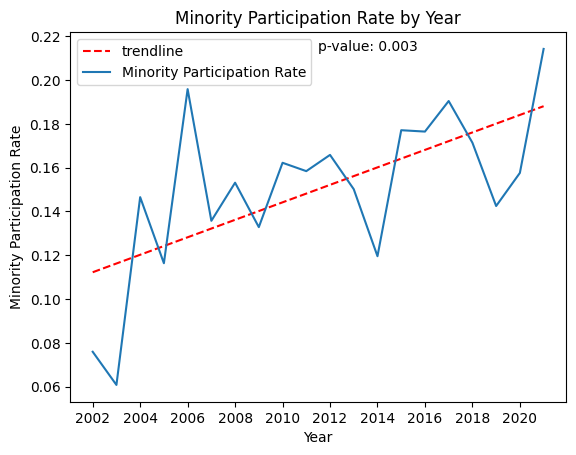

In [6]:
x = minority_participation_agg["Start Year"]
y = minority_participation_agg["minority_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.50, 0.95), xycoords='axes fraction')

# Plot the minority participation rate by year.
plt.plot(minority_participation_agg["Start Year"], minority_participation_agg["minority_participation_rate"], label="Minority Participation Rate")
plt.xlabel("Year")
plt.xticks(minority_participation_agg["Start Year"][::2])
plt.ylabel("Minority Participation Rate")
plt.title("Minority Participation Rate by Year")
plt.legend()
plt.savefig("plots/minority_participation_rate.png")
plt.show()

In [7]:
# 2. Rate of female participation by year. "Female" and "Male" are the columns
gender_columns = ["Female", "Male"]
gender_participation_agg = df.groupby("Start Year").agg({k: "sum" for k in gender_columns}).reset_index()
gender_participation_agg = gender_participation_agg.astype(int)
gender_participation_agg["total_participants"] = gender_participation_agg.apply("sum", axis=1) - gender_participation_agg["Start Year"]
gender_participation_agg["female_participation_rate"] = gender_participation_agg["Female"] / gender_participation_agg["total_participants"]
gender_participation_agg = gender_participation_agg[(minority_participation_agg["Start Year"] >= 2002) & (gender_participation_agg["Start Year"] <= 2021)]

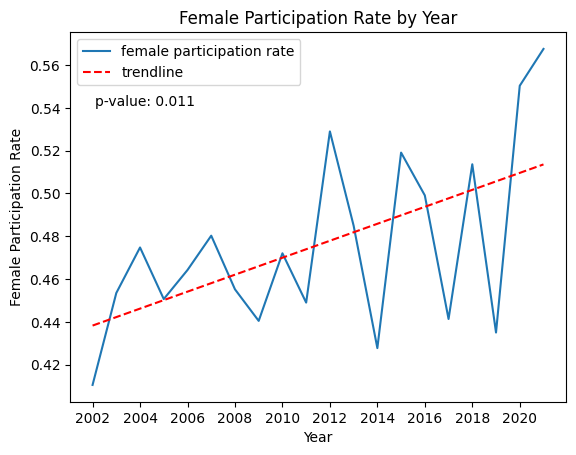

In [8]:
# Plot the female participation rate by year.
plt.plot(gender_participation_agg["Start Year"], gender_participation_agg["female_participation_rate"], label="female participation rate")
plt.xlabel("Year")
plt.xticks(gender_participation_agg["Start Year"][::2])
plt.ylabel("Female Participation Rate")
plt.title("Female Participation Rate by Year")

# Add trendline and p-value annotation
from scipy import stats
x = gender_participation_agg["Start Year"]
y = gender_participation_agg["female_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.legend()
plt.savefig("plots/female_participation_rate.png")
plt.show()

In [9]:
# 1. Rate of Hispanic participation by year. "Hispanic" is the column, "Non-His" and "Unknown Ethnicity" are the other columns
hispanic_agg = df.groupby("Start Year").agg({"Hispanic": "sum", "Non-His": "sum", "Unknown Ethnicity": "sum"}).reset_index()
hispanic_agg = hispanic_agg.astype(int)
hispanic_agg["total_participants"] = hispanic_agg.apply("sum", axis=1) - hispanic_agg["Start Year"]
hispanic_agg["hispanic_participation_rate"] = hispanic_agg["Hispanic"] / hispanic_agg["total_participants"]
hispanic_agg = hispanic_agg[(hispanic_agg["Start Year"] >= 2002) & (hispanic_agg["Start Year"] <= 2021)]

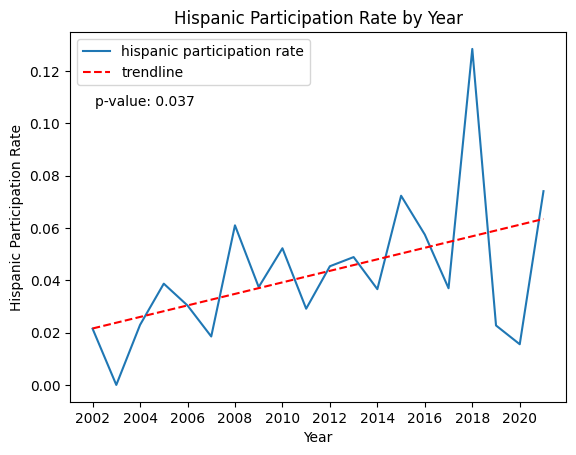

In [10]:
# Plot the hispanic participation rate by year.
plt.plot(hispanic_agg["Start Year"], hispanic_agg["hispanic_participation_rate"], label="hispanic participation rate")
plt.xlabel("Year")
plt.xticks(hispanic_agg["Start Year"][::2])
plt.ylabel("Hispanic Participation Rate")
plt.title("Hispanic Participation Rate by Year")

# Add trendline and p-value annotation
from scipy import stats
x = hispanic_agg["Start Year"]
y = hispanic_agg["hispanic_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')
plt.legend()
plt.savefig("plots/hispanic_participation_rate.png")
plt.show()

In [11]:
# Check if the difference in minority participation rate is significant
minority_df = df[df["White"].notna()]
minority_surgery_participation = df.groupby("Surgery?").agg({"minority_number": "sum", "Total Number": "sum"}).reset_index()
minority_surgery_participation["minority_surgery_participation_rate"] = minority_surgery_participation["minority_number"] / minority_surgery_participation["Total Number"]

# minority_surgery_participation_yes = minority_df[minority_df["Surgery?"] == 1.0]
# # fillna(0) because there are some NaN values in the minority participation rate column
# minority_surgery_participation_yes["minority_surgery_participation_rate"].fillna(0, inplace=True)
# minority_surgery_participation_no = minority_df[minority_df["Surgery?"] == 0.0]
# minority_surgery_participation_no["minority_surgery_participation_rate"].fillna(0, inplace=True)
# stats.ttest_ind(minority_surgery_participation_yes["minority_surgery_participation_rate"], minority_surgery_participation_no["minority_surgery_participation_rate"])

In [12]:
# Repeat for women
women_surgery_participation = df.groupby("Surgery?").agg({"Female": "sum", "Total Number": "sum"}).reset_index()
women_surgery_participation["female_participation_rate"] = women_surgery_participation["Female"] / women_surgery_participation["Total Number"]

In [13]:
# Check if the difference in minority participation rate is significant
df["female_participation_rate"] = df["Female"] / df["Total Number"]
women_surgery_participation_yes = df[df["Surgery?"] == 1.0]
# fillna(0) because there are some NaN values in the minority participation rate column
women_surgery_participation_yes["female_participation_rate"].fillna(0, inplace=True)
women_surgery_participation_no = df[df["Surgery?"] == 0.0]
women_surgery_participation_no["female_participation_rate"].fillna(0, inplace=True)
stats.ttest_ind(women_surgery_participation_yes["female_participation_rate"], women_surgery_participation_no["female_participation_rate"])

TtestResult(statistic=-0.15332108771657293, pvalue=0.8781860400137724, df=755.0)

In [14]:
# subset where "Hispanic" is not NaN
hispanic_df = df[df["Hispanic"].notna()]
hispanic_surgery_participation = hispanic_df.groupby("Surgery?").agg({"Hispanic": "sum", "Total Number": "sum"}).reset_index()
hispanic_surgery_participation["hispanic_participation_rate"] = hispanic_surgery_participation["Hispanic"] / hispanic_surgery_participation["Total Number"]
hispanic_surgery_participation

,Surgery?,Hispanic,Total Number,hispanic_participation_rate
0,0.0,779.0,16030.0,0.048596
1,1.0,0.0,57.0,0.000000


In [15]:
# Merge minority_surgery_participation, women_surgery_participation, and hispanic_surgery_participation into one dataframe on Surgery?, keeping 
# only the columns for the rates
dfs_to_merge = [minority_surgery_participation, women_surgery_participation, hispanic_surgery_participation]
merged_df = dfs_to_merge[0]
for surgery_df in dfs_to_merge[1:]:
    merged_df = pd.merge(merged_df, surgery_df, on="Surgery?")

merged_df = merged_df[["Surgery?", "minority_surgery_participation_rate", "female_participation_rate", "hispanic_participation_rate"]]
merged_df.columns = ["Surgery?", "minority_surgery_participation_rate", "female_surgery_participation_rate", "hispanic_surgery_participation_rate"]

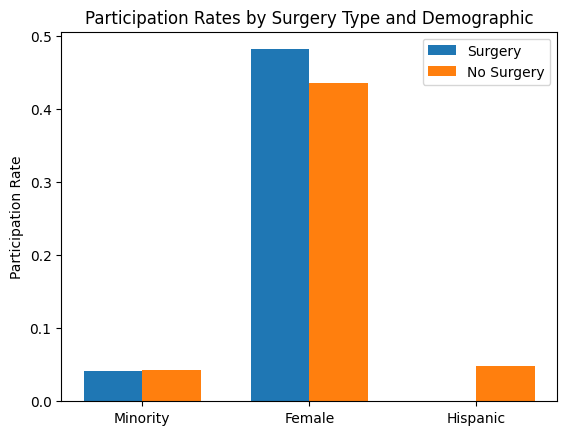

In [16]:
# Plot participation rates for both surgery and non-surgery as bar charts.
# x-axis is participation type: minority_surgery_participation_rate, female_participation_rate, hispanic_participation_rate
# Surgery? == 1.0 is surgery, Surgery? == 0.0 is no surgery. Group the two surgery types together for each participation type.
# y-axis is participation rate
participation_types = ["Minority", "Female", "Hispanic"]
surgery_participation_rates = [merged_df[merged_df["Surgery?"] == 1.0]["minority_surgery_participation_rate"].mean(),
                              merged_df[merged_df["Surgery?"] == 1.0]["female_surgery_participation_rate"].mean(),
                              merged_df[merged_df["Surgery?"] == 1.0]["hispanic_surgery_participation_rate"].mean()]
no_surgery_participation_rates = [merged_df[merged_df["Surgery?"] == 0.0]["minority_surgery_participation_rate"].mean(),
                                  merged_df[merged_df["Surgery?"] == 0.0]["female_surgery_participation_rate"].mean(),
                                  merged_df[merged_df["Surgery?"] == 0.0]["hispanic_surgery_participation_rate"].mean()]

x = np.arange(len(participation_types))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, surgery_participation_rates, width, label='Surgery')
rects2 = ax.bar(x + width/2, no_surgery_participation_rates, width, label='No Surgery')

ax.set_ylabel('Participation Rate')
ax.set_title('Participation Rates by Surgery Type and Demographic')
ax.set_xticks(x)
ax.set_xticklabels(participation_types)
ax.legend()
plt.savefig("plots/surgery_participation_barchart.png")
plt.show()

In [17]:
# 5. Does the rate of female/minority/Hispanic participation charge by funding type?

In [18]:
minority_df = df[df["White"].notna()]
minority_df["minority_participation_rate"] = minority_df["minority_number"] / minority_df["Total Number"]
minority_funder_participation = df.groupby("Funder Type").agg({"minority_number": "sum", "Total Number": "sum"}).reset_index()
minority_funder_participation["minority_participation_rate"] = minority_funder_participation["minority_number"] / minority_funder_participation["Total Number"]
minority_funder_participation

,Funder Type,minority_number,Total Number,minority_participation_rate
0,INDUSTRY,1428.0,13833.0,0.103231
1,NIH,551.0,58370.0,0.009440
2,OTHER,2231.0,24593.0,0.090717


In [19]:
# Repeat the above for female participation
women_funder_participation = df.groupby("Funder Type").agg({"Female": "sum", "Total Number": "sum"}).reset_index()
women_funder_participation["female_participation_rate"] = women_funder_participation["Female"] / women_funder_participation["Total Number"]
women_funder_participation

,Funder Type,Female,Total Number,female_participation_rate
0,INDUSTRY,6313.0,13833.0,0.456372
1,NIH,24307.0,58370.0,0.416430
2,OTHER,11571.0,24593.0,0.470500


In [20]:
hispanic_df = df[df["Hispanic"].notna()]
hispanic_funder_participation = hispanic_df.groupby("Funder Type").agg({"Hispanic": "sum", "Total Number": "sum"}).reset_index()
hispanic_funder_participation["hispanic_participation_rate"] = hispanic_funder_participation["Hispanic"] / hispanic_funder_participation["Total Number"]
hispanic_funder_participation

,Funder Type,Hispanic,Total Number,hispanic_participation_rate
0,INDUSTRY,283.0,5852.0,0.048360
1,NIH,86.0,2175.0,0.039540
2,OTHER,410.0,8060.0,0.050868


In [21]:
# Merge minority_surgery_participation, women_surgery_participation, and hispanic_surgery_participation into one dataframe on Surgery?, keeping 
# only the columns for the rates
dfs_to_merge = [minority_funder_participation, women_funder_participation, hispanic_funder_participation]
merged_df = dfs_to_merge[0]
for funder_df in dfs_to_merge[1:]:
    merged_df = pd.merge(merged_df, funder_df, on="Funder Type")
merged_df = merged_df[["Funder Type", "minority_participation_rate", "female_participation_rate", "hispanic_participation_rate"]]
merged_df

,Funder Type,minority_participation_rate,female_participation_rate,hispanic_participation_rate
0,INDUSTRY,0.103231,0.456372,0.048360
1,NIH,0.009440,0.416430,0.039540
2,OTHER,0.090717,0.470500,0.050868


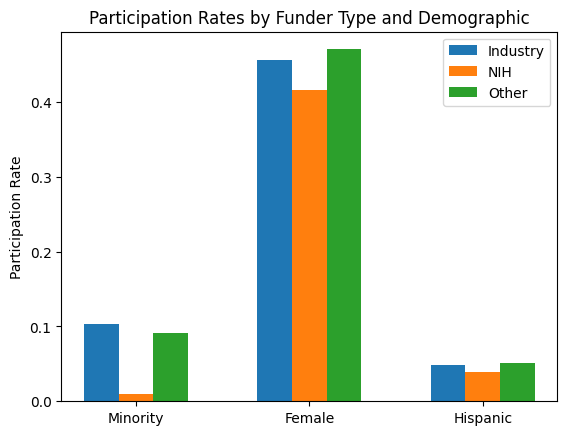

In [22]:
# Plot participation rates for all three funder types as bar charts.
# x-axis is participation type: minority_surgery_participation_rate, female_participation_rate, hispanic_participation_rate
# Funder Type == "INDUSTRY", "NIH", and "OTHER". Group the three funder types together for each participation type.
# y-axis is participation rate
participation_types = ["Minority", "Female", "Hispanic"]
industry_participation_rates = [merged_df[merged_df["Funder Type"] == "INDUSTRY"]["minority_participation_rate"].mean(),
                                merged_df[merged_df["Funder Type"] == "INDUSTRY"]["female_participation_rate"].mean(),
                                merged_df[merged_df["Funder Type"] == "INDUSTRY"]["hispanic_participation_rate"].mean()]
nih_participation_rates = [merged_df[merged_df["Funder Type"] == "NIH"]["minority_participation_rate"].mean(),
                           merged_df[merged_df["Funder Type"] == "NIH"]["female_participation_rate"].mean(),
                           merged_df[merged_df["Funder Type"] == "NIH"]["hispanic_participation_rate"].mean()]
other_participation_rates = [merged_df[merged_df["Funder Type"] == "OTHER"]["minority_participation_rate"].mean(),
                             merged_df[merged_df["Funder Type"] == "OTHER"]["female_participation_rate"].mean(),
                             merged_df[merged_df["Funder Type"] == "OTHER"]["hispanic_participation_rate"].mean()]

x = np.arange(len(participation_types))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, industry_participation_rates, width, label='Industry')
rects2 = ax.bar(x, nih_participation_rates, width, label='NIH')
rects3 = ax.bar(x + width, other_participation_rates, width, label='Other')

ax.set_ylabel('Participation Rate')
ax.set_title('Participation Rates by Funder Type and Demographic')
ax.set_xticks(x)
ax.set_xticklabels(participation_types)
ax.legend()
plt.savefig("plots/funder_type_participation_barchart.png")
plt.show()

In [23]:
# 6. Has reporting of ethnicity or race changed over time?

# Group by year and get rate of reporting for ethnicity. i.e. per year, rate of has_race == 1 versus has_race == 0
graph_six_df = df.groupby("Start Year").agg({"has_ethnicity": ["mean", "count"]})
graph_six_df.columns = ["ethnicity_reporting_rate", "total_patients"]

slope: 0.042645    intercept: -85.366126
R-squared: 0.937850
p-value: 0.000000


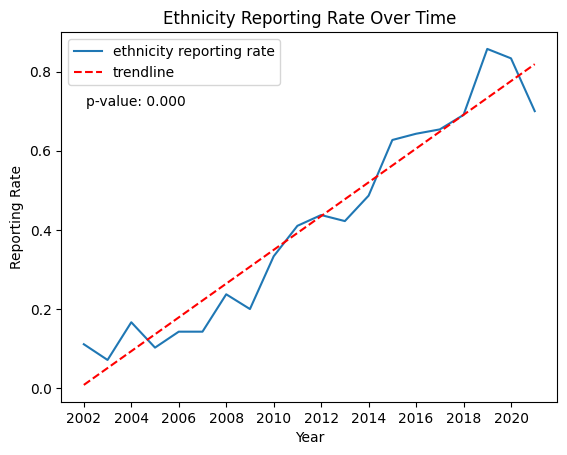

In [24]:
# Plot "ethnicity_reporting_rate" over time 2002-2021
graph_six_df = graph_six_df[graph_six_df.index >= 2002]
plt.plot(graph_six_df.index, graph_six_df["ethnicity_reporting_rate"], label="ethnicity reporting rate")

# Plot trendline and p-value to the graph
x = graph_six_df.index
y = graph_six_df["ethnicity_reporting_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.title("Ethnicity Reporting Rate Over Time")
plt.xlabel("Year")
plt.xticks(graph_six_df.index[::2])
plt.ylabel("Reporting Rate")
plt.legend()
plt.savefig("plots/ethnicity_reporting_rate.png")
plt.show()

slope: 0.041881    intercept: -83.647993
R-squared: 0.847186
p-value: 0.000000


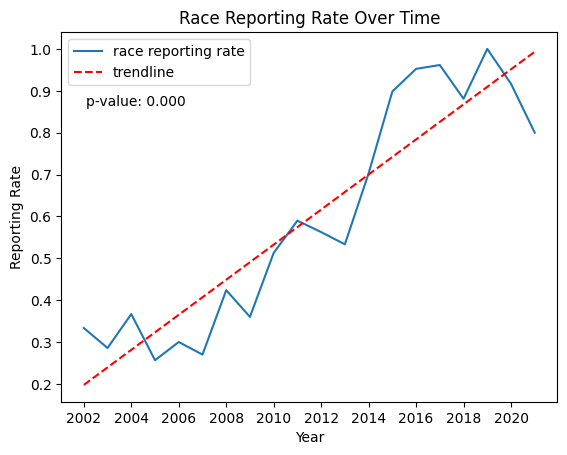

In [25]:
# Group by year and get rate of reporting for race. i.e. per year, rate of has_race == 1 versus has_race == 0
graph_six_df = df.groupby("Start Year").agg({"has_race": ["mean", "count"]})
graph_six_df.columns = ["race_reporting_rate", "total_patients"]

graph_six_df = graph_six_df[graph_six_df.index >= 2002]
plt.plot(graph_six_df.index, graph_six_df["race_reporting_rate"], label="race reporting rate")

# Plot trendline and p-value to the graph
x = graph_six_df.index
y = graph_six_df["race_reporting_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.title("Race Reporting Rate Over Time")
plt.xlabel("Year")
plt.xticks(graph_six_df.index[::2])
plt.ylabel("Reporting Rate")
plt.legend()
plt.savefig("plots/race_reporting_rate.png")
plt.show()